In [18]:
# camera calibration
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob

#read in all images
images = glob.glob('camera_cal/calibration*.jpg')


objpoints = []
imgpoints = []

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)


for fname in images:
    #read in each image
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
 


In [19]:
#load in one image to get the shape
img = mpimg.imread('camera_cal/calibration1.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY) #just to get the shape
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

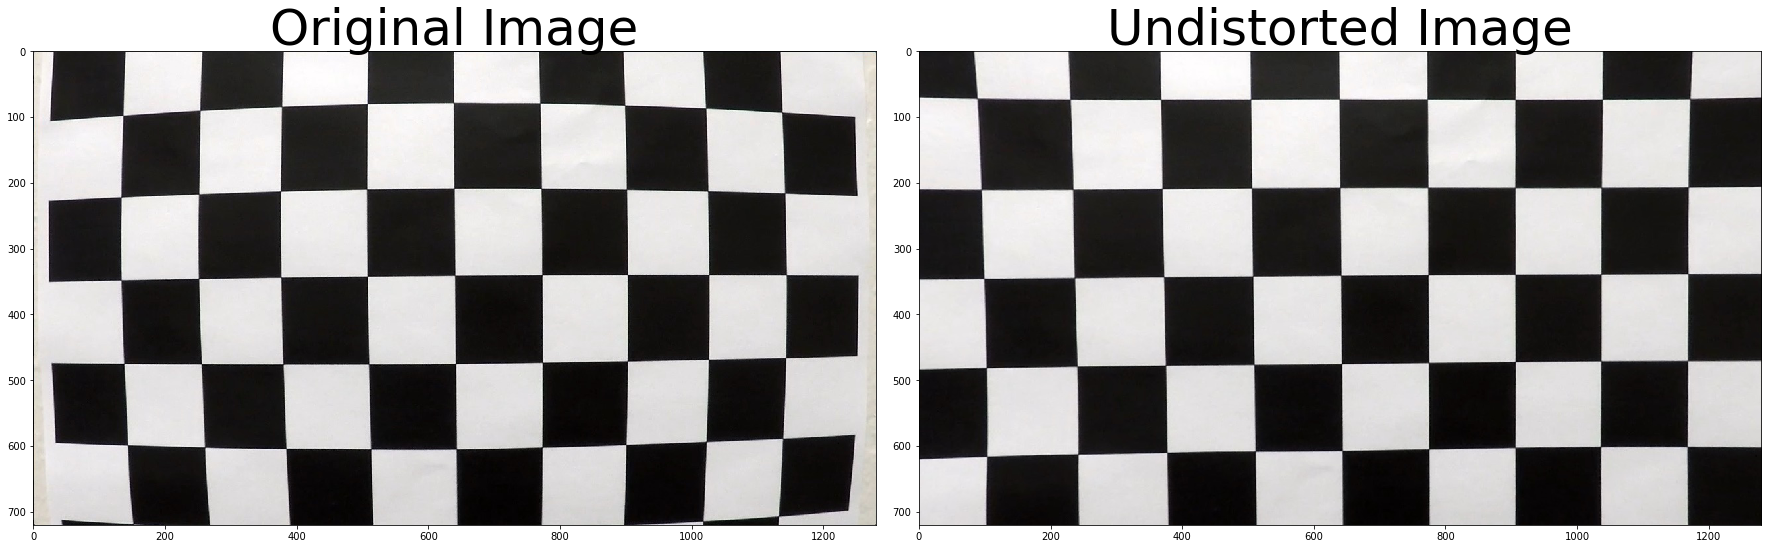

In [23]:
#show one example

dst = cv2.undistort(img, mtx, dist, None, mtx)
%matplotlib inline
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

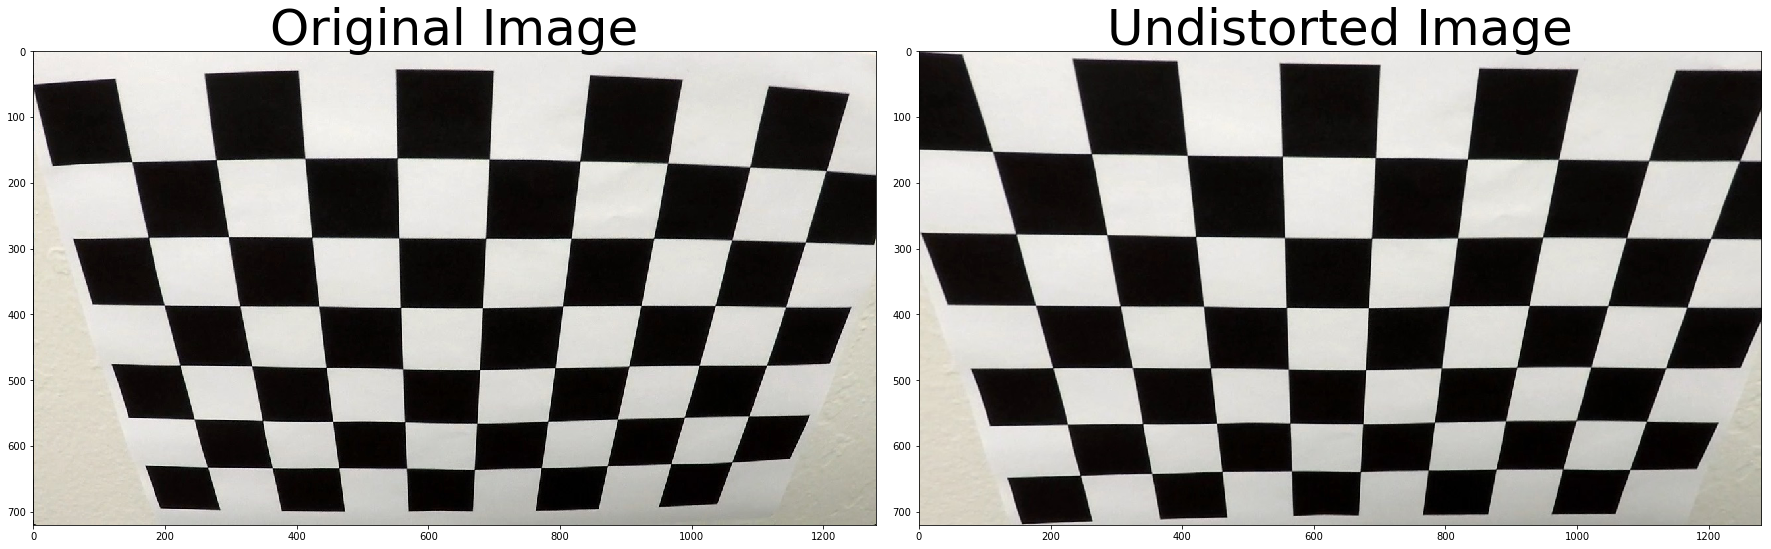

In [25]:
#show another example
img2 = mpimg.imread('camera_cal/calibration2.jpg')
dst2 = cv2.undistort(img2, mtx, dist, None, mtx)
%matplotlib inline
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img2)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst2)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

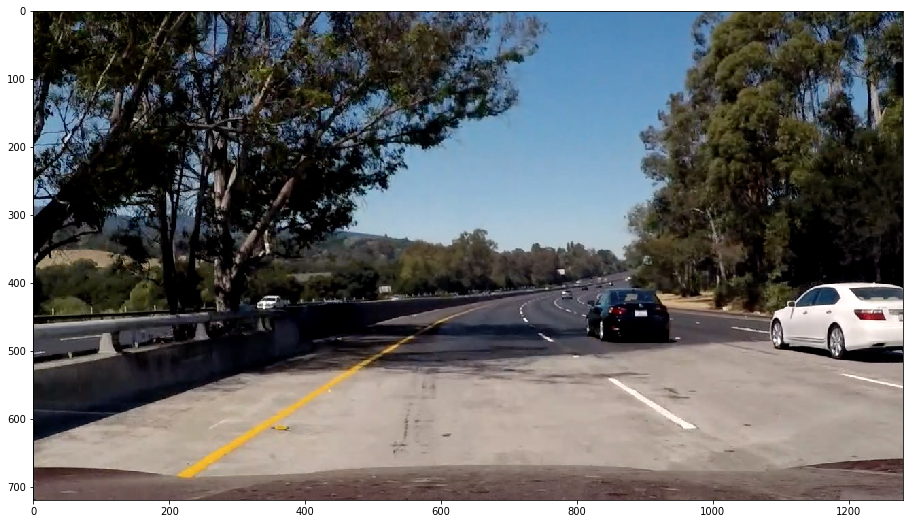

In [26]:
# applying distortion to a test image
test_image = mpimg.imread('test_images/test5.jpg')
%matplotlib inline
f, ax = plt.subplots(1, 1, figsize=(24, 9))
ax.imshow(test_image)


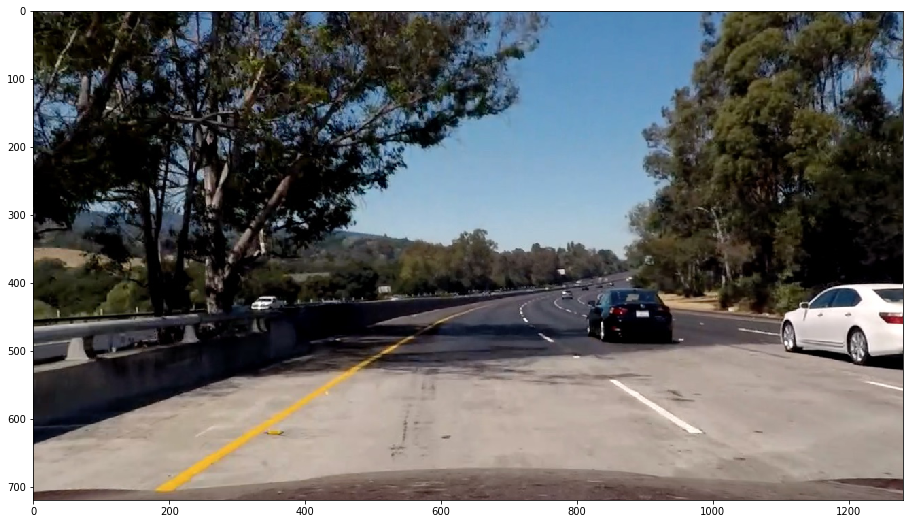

In [54]:
#undistort
dst_test = cv2.undistort(test_image, mtx, dist, None, mtx)
%matplotlib inline
f, ax = plt.subplots(1, 1, figsize=(24, 9))
ax.imshow(dst_test)


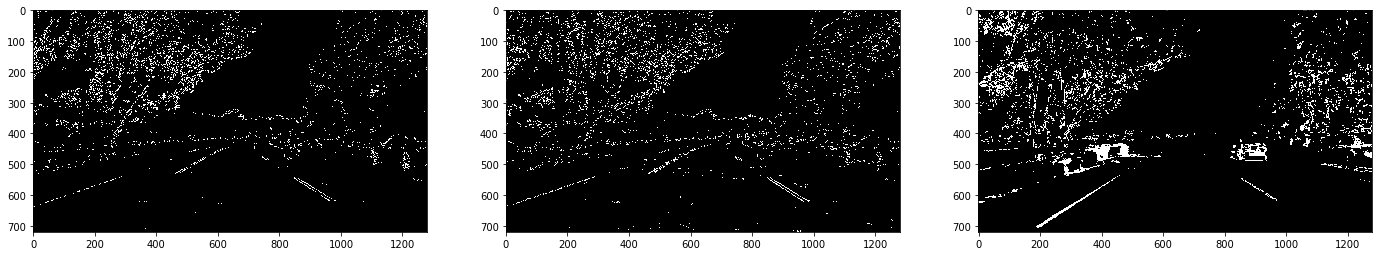

In [69]:
#thresholding pipeline to detect the edges
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)

    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    sobelmag = np.sqrt(np.sum([np.square(sobelx), np.square(sobely)], axis=0 ))
    scaled_sobel = np.uint8(255*sobelmag/np.max(sobelmag))

    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    sobel_angle = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(sobel_angle)
    dir_binary[(sobel_angle >= thresh[0]) & (sobel_angle <= thresh[1])] = 1
    return dir_binary

def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(dst_test, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(dst_test, orient='y', sobel_kernel=ksize, thresh=(20, 100))
gradient_binary = np.zeros_like(grady)
#combine absolute gradients
gradient_binary[(gradx == 1) & (grady == 1)] = 1
mag_binary = mag_thresh(dst_test, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(dst_test, sobel_kernel=15, thresh=(0.7, 1.3))
#combine magnitude and directional threshold
mag_dir_binary = np.zeros_like(dir_binary)
mag_dir_binary[(mag_binary == 1) & (dir_binary == 1)] = 1
#hls colorspace
hls_binary = hls_select(dst_test, thresh=(190, 255))
%matplotlib inline
f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(24, 9))
#show the three threshold
ax1.imshow(gradient_binary, cmap='gray')     
ax2.imshow(mag_dir_binary,cmap='gray')    
ax3.imshow(hls_binary,cmap='gray')    




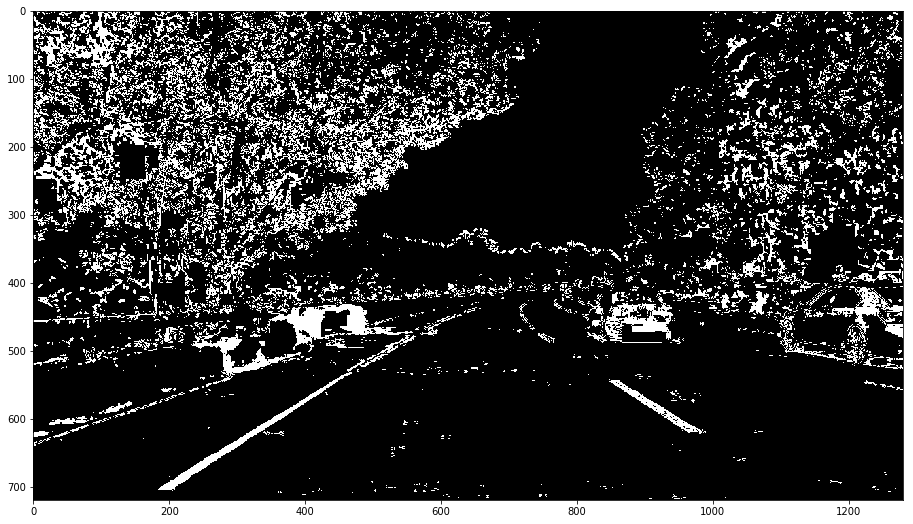

In [56]:
combined_binary = np.zeros_like(hls_binary)
combined_binary[(gradient_binary == 1) | (mag_dir_binary == 1)|(hls_binary == 1)] = 1
%matplotlib inline
f, ax = plt.subplots(1, 1, figsize=(24, 9))
#show the resulting image combing three threshold
ax.imshow(combined_binary, cmap= 'gray')                    


(1280, 720)


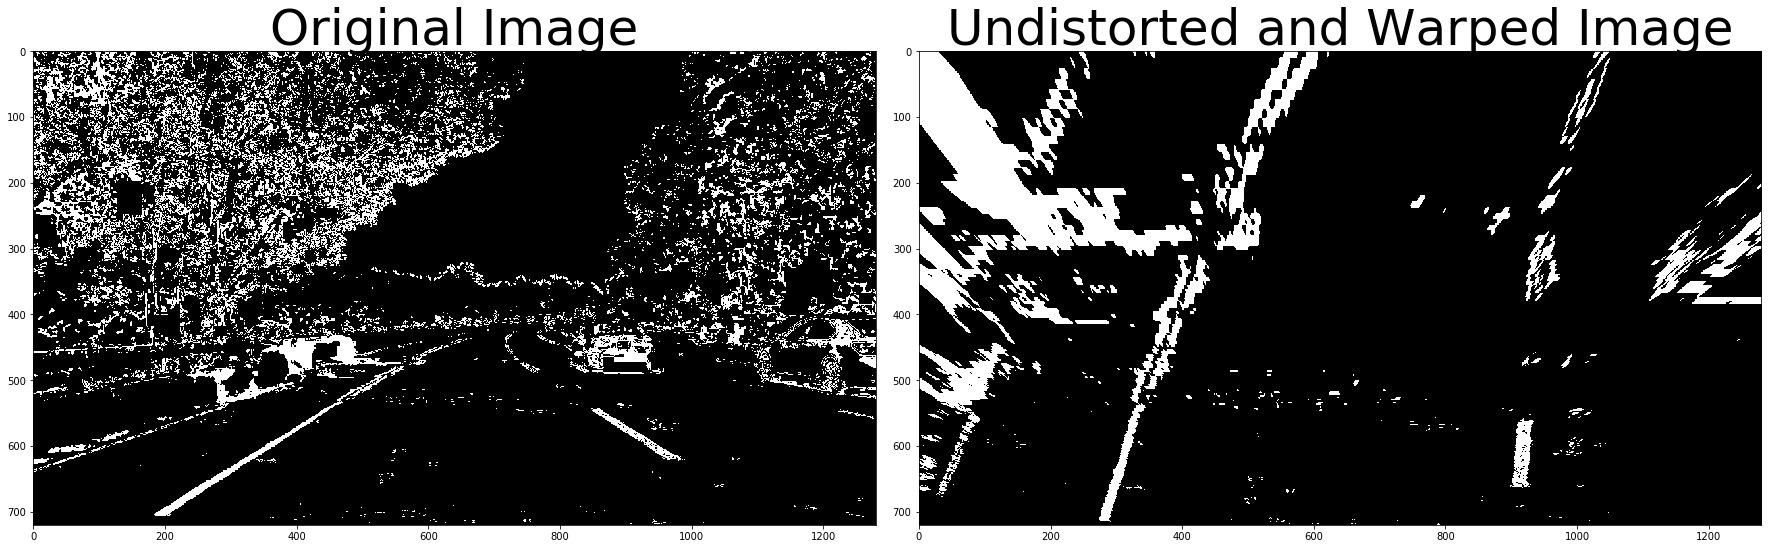

In [74]:
#perspective transform 
img_size =( combined_binary.shape[1], test_image.shape[0])
print(img_size)
#TUNE the points until the lanes are parallel
src = np.float32([[550,450],[700,450], [1200, img_size[1]], [200, img_size[1]]])
dst = np.float32([[300,0],[950,0],[950, img_size[1]],[300, img_size[1]]])
M = cv2.getPerspectiveTransform(src,dst)
Minv = cv2.getPerspectiveTransform(dst, src)
binary_warped = cv2.warpPerspective(combined_binary, M, img_size, flags=cv2.INTER_LINEAR)
%matplotlib inline
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined_binary, cmap= 'gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(binary_warped, cmap= 'gray')
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)






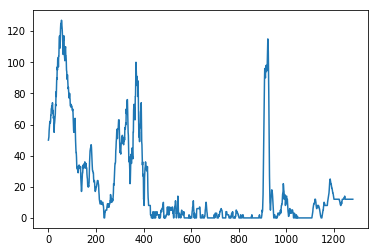

In [76]:
#detect lanes
import numpy as np
import cv2
import matplotlib.pyplot as plt


histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255


In [77]:
midpoint = np.int(histogram.shape[0]/2)
#Peak on the left
leftx_base = np.argmax(histogram[:midpoint])
print(leftx_base)
#peak on the right
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
print(rightx_base)

55
922


In [78]:
#initialize line class to track
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None